In [1]:
import planetary_computer
import pystac_client
from IPython.display import display, Markdown
import rioxarray
import geopandas as gpd
from IPython.display import Image
import stackstac # build an on-demand STAC data cube
from rasterio.enums import Resampling
import shapely # create vector objects
import dask.array as da # handle dask arrays
import pandas as pd
import numpy as np
import xarray as xr
import rich.table
import fsspec
from datetime import datetime

import warnings
warnings.simplefilter("ignore", category=UserWarning)
print("Packages loaded successfully")

Packages loaded successfully


### Extracting Sentinel-1

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
collection = catalog.get_collection("sentinel-1-grd")

display(Markdown(f"### {collection.id}\n\n{collection.description}"))

### sentinel-1-grd

The [Sentinel-1](https://sentinel.esa.int/web/sentinel/missions/sentinel-1) mission is a constellation of two polar-orbiting satellites, operating day and night performing C-band synthetic aperture radar imaging. The Level-1 Ground Range Detected (GRD) products in this Collection consist of focused SAR data that has been detected, multi-looked and projected to ground range using the Earth ellipsoid model WGS84. The ellipsoid projection of the GRD products is corrected using the terrain height specified in the product general annotation. The terrain height used varies in azimuth but is constant in range (but can be different for each IW/EW sub-swath).

Ground range coordinates are the slant range coordinates projected onto the ellipsoid of the Earth. Pixel values represent detected amplitude. Phase information is lost. The resulting product has approximately square resolution pixels and square pixel spacing with reduced speckle at a cost of reduced spatial resolution.

For the IW and EW GRD products, multi-looking is performed on each burst individually. All bursts in all sub-swaths are then seamlessly merged to form a single, contiguous, ground range, detected image per polarization.

For more information see the [ESA documentation](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-1-sar/product-types-processing-levels/level-1)

### Terrain Correction

Users might want to geometrically or radiometrically terrain correct the Sentinel-1 GRD data from this collection. The [Sentinel-1-RTC Collection](https://planetarycomputer.microsoft.com/dataset/sentinel-1-rtc) collection is a global radiometrically terrain corrected dataset derived from Sentinel-1 GRD. Additionally, users can terrain-correct on the fly using [any DEM available on the Planetary Computer](https://planetarycomputer.microsoft.com/catalog?tags=DEM). See [Customizable radiometric terrain correction](https://planetarycomputer.microsoft.com/docs/tutorials/customizable-rtc-sentinel1/) for more.

## Choose an Area and time of interest

In [3]:
time_of_interest = "2024-01-01/2024-12-31"

bbox_of_interest = [33.9, 0.1, 34.6, 0.8]

search = catalog.search(
    collections=["sentinel-1-grd"],
    bbox=bbox_of_interest,
    datetime=time_of_interest,
)
items = search.item_collection()
print(f"Returned {len(items)} Items of Sentinel-1 for Busia County")

Returned 102 Items of Sentinel-1 for Busia County


In [4]:
from IPython.display import Image

item = items[0]
Image(url=item.assets["rendered_preview"].href)

### Inspect the STAC metadata

In [5]:
table = rich.table.Table("key", "value")
for k, v in sorted(item.properties.items()):
    table.add_row(k, str(v))

table

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ key                                   ┃ value                            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ constellation                         │ Sentinel-1                       │
│ datetime                              │ 2024-12-25T16:05:32.076652Z      │
│ end_datetime                          │ 2024-12-25 16:05:44.575793+00:00 │
│ platform                              │ SENTINEL-1A                      │
│ s1:datatake_id                        │ 460543                           │
│ s1:instrument_configuration_ID        │ 7                                │
│ s1:orbit_source                       │ RESORB                           │
│ s1:processing_level                   │ 1                                │
│ s1:product_timeliness                 │ Fast-24h                         │
│ s1:resolution                         │ high                             │
│ s1:shape                              │ [25518, 16827]                   │
│ s1:slice_number                       │ 9                                │
│ s1:total_slices                       │ 11                               │
│ sar:center_frequency                  │ 5.405                            │
│ sar:frequency_band                    │ C                                │
│ sar:instrument_mode                   │ IW                               │
│ sar:looks_azimuth                     │ 1                                │
│ sar:looks_equivalent_number           │ 4.4                              │
│ sar:looks_range                       │ 5                                │
│ sar:observation_direction             │ right                            │
│ sar:pixel_spacing_azimuth             │ 10                               │
│ sar:pixel_spacing_range               │ 10                               │
│ sar:polarizations                     │ ['VV', 'VH']                     │
│ sar:product_type                      │ GRD                              │
│ sar:resolution_azimuth                │ 22                               │
│ sar:resolution_range                  │ 20                               │
│ sat:absolute_orbit                    │ 57150                            │
│ sat:orbit_state                       │ ascending                        │
│ sat:platform_international_designator │ 2014-016A                        │
│ sat:relative_orbit                    │ 28                               │
│ start_datetime                        │ 2024-12-25 16:05:19.577511+00:00 │
└───────────────────────────────────────┴──────────────────────────────────┘

The item's data assets will be some combination of vh, vv, hv, and hh, depending on the polarization the signal was transmitted and received in. In this case, the item has vv and vh assets. In general, check the sar:polarizations field for what is available.

In [6]:
item.properties["sar:polarizations"]

['VV', 'VH']

#### Visualize the Asset

In [7]:
vv = (
    rioxarray.open_rasterio(item.assets["vv"].href, overview_level=2)
    .astype(float)
    .squeeze()
)
vh = (
    rioxarray.open_rasterio(item.assets["vh"].href, overview_level=2)
    .astype(float)
    .squeeze()
)

We can plot this distribution of the pixel values, to get a sense for their range. The raw values are fairly skewed, so it's common to render with an amplitude scale (taking the square root of the value) or a dB scale ($10 \times log_{10}$ of the value).

In [8]:
import pandas as pd
import seaborn as sns

raw = vv.where(lambda x: x > 0).data.ravel()
df = (
    pd.DataFrame({"power": raw, "amplitude": np.sqrt(raw), "dB": 10 * np.log10(raw)})
    .dropna()
    .melt(value_vars=["power", "amplitude", "dB"], var_name="kind")
)

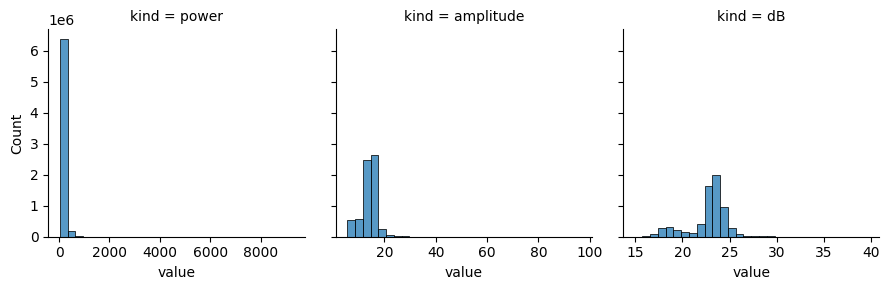

In [9]:
g = sns.FacetGrid(df, sharex=False, col="kind")
g.map(sns.histplot, "value", bins=30);

Now let's recreate the false-color image from the data API, using a combination of the two bands. We'll use vv as the red band, vh as the green band, and vv / vh as the green band. We'll rescale it as well (using values from the mosaic/info endpoint).

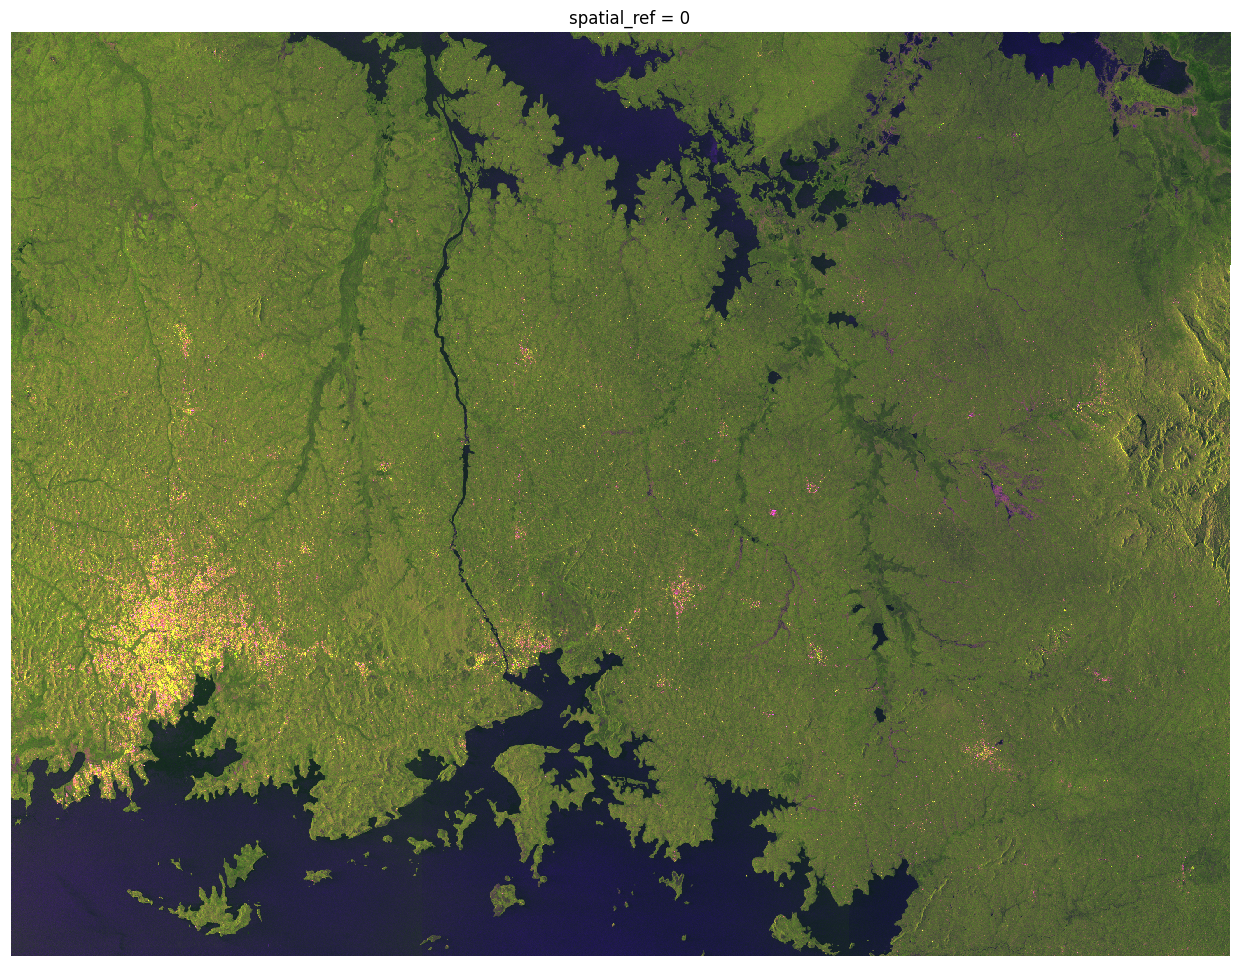

In [10]:
r = vv / 600
g = vh / 270
b = (vv / vh) / 9
data = xr.concat([r, g, b], dim="band").clip(0, 1).where(lambda x: x > 0)
img = data.plot.imshow(rgb="band", size=12)
img.axes.set_axis_off()

By default, some Sentinel-1 GRD images may appear "upside-down". Seattle, the brightest spot area, appears towards the top-left of the image, despite being in the southwest of the area.

Whether the data needs to be flipped depends on the mode the satellite was in when the image was captured, which is available from the sat:orbit_state property in the STAC metadata.

In [11]:
item.properties["sat:orbit_state"]

'ascending'

In this case, the satellite was in "ascending" mode, and so we do not need to flip the image. If it could be descending, we could flip it using the code below

In [12]:
# img = np.flip(data, axis=(1, 2)).clip(0, 1).plot.imshow(size=12)
# img.axes.set_axis_off()

### GRD Products

In [13]:
search = catalog.search(
    collections=["sentinel-1-grd"],
    query={
        "sar:instrument_mode": {"eq": "SM"},
        "sar:polarizations": {"eq": ["VV", "VH"]},
    },
    limit=5,
)

gen = search.items()
item = next(gen)

Image(url=item.assets["rendered_preview"].href)